In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sn

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from util_scripts.util_mnist_reader import load_mnist
from collections import Counter
from sklearn.decomposition import PCA
from scipy.stats import mode

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD

from keras.utils import plot_model
from IPython.display import Image

Using TensorFlow backend.


In [2]:
X_train, y_train = load_mnist("util_scripts/data/fashion", kind='train')
X_test, y_test = load_mnist("util_scripts/data/fashion", kind='t10k')

In [3]:
#Normalizing the data
x_train = X_train.reshape((len(X_train)),-1)/255.0
x_test = X_test.reshape((len(X_test)),-1)/255.0

## 1.1 Create Clusters using K-Means

In [4]:
kmeans = KMeans(n_clusters = 10)
clusters = kmeans.fit_predict(x_train)

In [5]:
print("y labels:", y_train)
print("clusters:", clusters)

y labels: [9 0 0 ... 3 0 5]
clusters: [3 2 9 ... 2 9 9]


In [6]:
#Map the Cluster Centroid values to the Ground Truth Values in y_train
def map_cluster_labels_to_ground_truth(clusters, y_train): 
    label_map = np.zeros_like(clusters)
    for i in range(kmeans.n_clusters):
        labels = (clusters == i)
        label_map[labels] = mode(y_train[labels])[0]
    return label_map

mapped_labels = map_cluster_labels_to_ground_truth(clusters, y_train)
training_accuracy = metrics.accuracy_score(y_true=y_train, y_pred=mapped_labels)
training_confusion_matrix = metrics.confusion_matrix(y_true=y_train, y_pred=mapped_labels)

#Using Test data
test_clusters = kmeans.predict(x_test)
mapped_test_labels = map_cluster_labels_to_ground_truth(test_clusters, y_test)
testing_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=mapped_test_labels)
testing_confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=mapped_test_labels)

### Training Results for K-Means Clustering

Training Accuracy for K-Means Clustering:
Training Accuracy: 0.55355


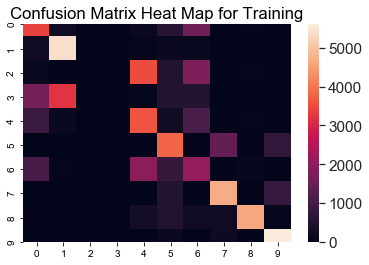

In [8]:
#Training Accuracy
print("Training Accuracy for K-Means Clustering:")
print("Training Accuracy:", training_accuracy)

#Confusion Matrix Heat Map
ax = plt.axes()
df_cm = pd.DataFrame(training_confusion_matrix, range(0,10), range(0,10))
sn.set(font_scale=1.4)
ax.set_title('Confusion Matrix Heat Map for Training')
sn.heatmap(df_cm, annot_kws={"size": 16})# font size
plt.show()

### Testing Results For K-means Clustering

Testing accuracy for kmeans clustering:
Testing Accuracy: 0.5601


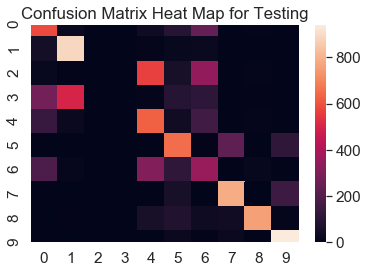

In [9]:
#Testing Accuracy
print("Testing accuracy for kmeans clustering:")
print("Testing Accuracy:", testing_accuracy)

#Confusion Matrix Heat Map
df_cm = pd.DataFrame(testing_confusion_matrix, range(0,10), range(0,10))
ax = plt.axes()
sn.set(font_scale=1.4)
ax.set_title('Confusion Matrix Heat Map for Testing')
sn.heatmap(df_cm, annot_kws={"size": 16})# font size
plt.show()

In [10]:
#Preparing Input data
input_image = Input(shape=(x_train.shape[-1],))

#define Autoencoder

#Encoder
AE = Sequential()
AE.add(Dense(512, activation='relu', input_shape=(x_train.shape[-1],)))
AE.add(Dense(256, activation='relu'))
AE.add(Dense(128, activation='relu'))

#Decoder
AE.add(Dense(256, activation='relu'))
AE.add(Dense(512, activation='relu'))
AE.add(Dense((x_train.shape[-1]), activation='sigmoid'))

AE.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 784)               402192    
Total params: 1,132,944
Trainable params: 1,132,944
Non-trainable params: 0
____________________________________________

In [11]:
#Defining Encoder by extracting it from AutoEncoder
enc_layer1 = AE.layers[0]
enc_layer2 = AE.layers[1]
enc_layer3 = AE.layers[2]
Encoder = Model(input_image, enc_layer3(enc_layer2(enc_layer1(input_image))))
Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
Total params: 566,144
Trainable params: 566,144
Non-trainable params: 0
_________________________________________________________________


In [12]:
#Compile the autoencoder
AE.compile(optimizer=SGD(lr=0.05, momentum=0.9), loss='mse')

AE_res = AE.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                validation_data=(x_test, x_test)
      )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.1281 - val_loss: 0.0916
Epoch 2/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.0873 - val_loss: 0.0780
Epoch 3/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.0681 - val_loss: 0.0597
Epoch 4/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.0543 - val_loss: 0.0496
Epoch 5/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.0472 - val_loss: 0.0450
Epoch 6/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.0437 - val_loss: 0.0421
Epoch 7/50
60000/60000 [==============================] - 4s 75us/step - loss: 0.0411 - val_loss: 0.0397
Epoch 8/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.0387 - val_loss: 0.0372
Epoch 9/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.0361 - val_loss: 0.0348
Epoch

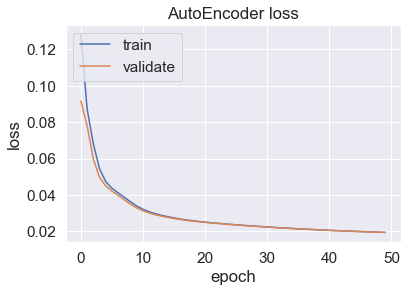

In [31]:
# Training Loss vs Validation Loss
plt.plot(AE_res.history['loss'])
plt.plot(AE_res.history['val_loss'])
plt.title('AutoEncoder loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()


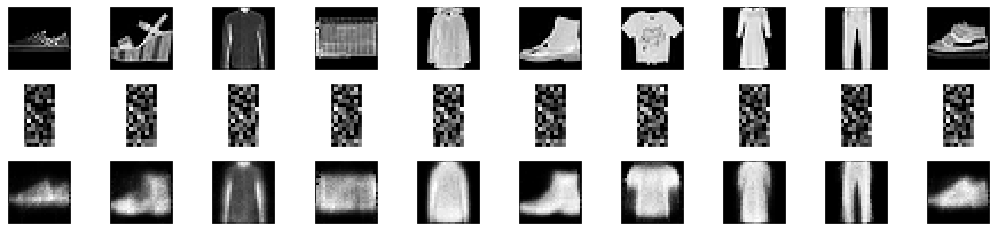

In [14]:
#Show the encoded and decoded image

#randomly pick 10 images from test data set
random_images = np.random.randint(x_test.shape[0], size=10)

#encode the images using encoder
encoded_images = Encoder.predict(x_test)

#decoded images 
decoded_images = AE.predict(x_test)


plt.figure(figsize=(18, 4))


for i, index in enumerate(random_images):
    # plot original image
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, 10,  i + 11)
    plt.imshow(encoded_images[index].reshape(16, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, 10, i + 21)
    plt.imshow(decoded_images[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. K-Means Clustering With Prior Encoding 

In [27]:
#Using the encoder with kmeans to generate clusters
encoded_training_data = Encoder.predict(x_train)

#Kmeans clustering
enc_kmeans = KMeans(n_clusters = 10, init='random')
enc_clusters = enc_kmeans.fit_predict(encoded_training_data)

In [28]:
enc_mapped_labels = map_cluster_labels_to_ground_truth(enc_clusters, y_train)
training_accuracy = metrics.accuracy_score(y_true=y_train, y_pred=enc_mapped_labels)
training_confusion_matrix = metrics.confusion_matrix(y_true=y_train, y_pred=enc_mapped_labels)

#Using Test data
encoded_test_data = Encoder.predict(x_test)
test_clusters = enc_kmeans.predict(encoded_test_data)
mapped_test_labels = map_cluster_labels_to_ground_truth(test_clusters, y_test)
testing_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=mapped_test_labels)
testing_confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=mapped_test_labels)

Testing accuracy for kmeans clustering:
Testing Accuracy: 0.5141
Confusion Matrix Heat Map for Testing Data: Kmeans


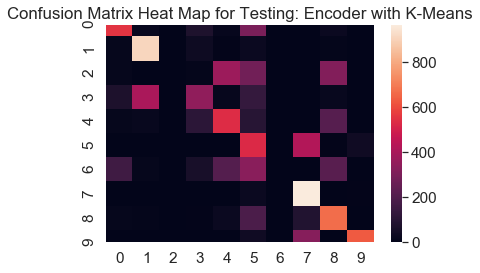

In [29]:
#Accuracy
print("Testing accuracy for kmeans clustering:")
print("Testing Accuracy:", testing_accuracy)

#Confusion Matrix Heat Map
print("Confusion Matrix Heat Map for Testing Data: Kmeans")
df_cm = pd.DataFrame(testing_confusion_matrix, range(0,10), range(0,10))
ax = plt.axes()
sn.set(font_scale=1.4)
ax.set_title('Confusion Matrix Heat Map for Testing: Encoder with K-Means')
sn.heatmap(df_cm, annot_kws={"size": 16})# font size
plt.show()

## 3. Gaussian Mixture Model Clustering with Prior Encoding

In [18]:
#Using the encoder with Gaussian Mixture Model to generate clusters
gmm_encoded_training_data = Encoder.predict(x_train)

#GMM clustering
enc_gmm = GaussianMixture(n_components = 10)
enc_gmm_clusters = enc_gmm.fit_predict(gmm_encoded_training_data)

In [19]:
gmm_enc_mapped_labels = map_cluster_labels_to_ground_truth(enc_gmm_clusters, y_train)
training_accuracy = metrics.accuracy_score(y_true=y_train, y_pred=gmm_enc_mapped_labels)
training_confusion_matrix = metrics.confusion_matrix(y_true=y_train, y_pred=gmm_enc_mapped_labels)

#Using Test data
gmm_encoded_test_data = Encoder.predict(x_test)
gmm_test_clusters = enc_gmm.predict(gmm_encoded_test_data)
gmm_mapped_test_labels = map_cluster_labels_to_ground_truth(gmm_test_clusters, y_test)
gmm_testing_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=gmm_mapped_test_labels)
gmm_testing_confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=gmm_mapped_test_labels)

Testing accuracy for Guassian Mixture Model clustering:
Testing Accuracy: 0.5575


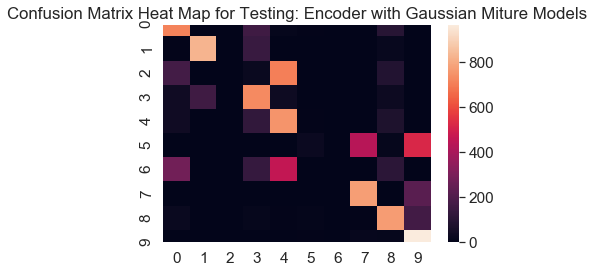

In [24]:
#Accuracy
print("Testing accuracy for Guassian Mixture Model clustering:")
print("Testing Accuracy:", gmm_testing_accuracy)

#Confusion Matrix Heat Map
df_cm = pd.DataFrame(gmm_testing_confusion_matrix, range(0,10), range(0,10))
ax = plt.axes()
sn.set(font_scale=1.4)
ax.set_title('Confusion Matrix Heat Map for Testing: Encoder with Gaussian Miture Models')
sn.heatmap(df_cm, annot_kws={"size": 16})# font size
plt.show()